<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/ML%20Homework%206%20-%20Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6 - Boosting
The purpose of this exercise is to examine the effects of various boosting methods on tree classification problems. Specifically random forest models generated using ADA boosting and Gradient boosting will be compared with a standard random forest.

 ## Packages & Variables

In [1]:
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#Plotting Packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

#Utilitie warnings
import pickle
import warnings
warnings.filterwarnings('ignore')
np.random.seed(235)
from google.colab import drive, files
drive.mount('/content/gdrive')
#uploaded = files.upload()
;

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


''

In [0]:
#GLOBAL & CONSTANTS
NUM = 4
INPUT_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
INPUT_DATA_FILE = ''

GD_CODE_DIR = '/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR = 'Machine Learning & Predictive Analytics/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'
LOGS_DIR = 'logs/'
HOMEWORK_DIR = 'Homework {}/'.format(NUM)
NOTEBOOK_NAME = 'Homework {}.ipynb'.format(NUM)

MAIN_PATH = os.path.join(GD_CODE_DIR
                        ,SUBJECT_DIR
                        ,HOMEWORK_DIR)

INPUT_FILE = os.path.join(MAIN_PATH
                          ,DATA_DIR
                          ,INPUT_DATA_FILE)

NOTEBOOK_FILE = os.path.join(MAIN_PATH
                            ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH = os.path.join(MAIN_PATH
                                ,MODEL_DIR)

LOG_PATH = os.path.join(MAIN_PATH
                       ,LOGS_DIR)


## Data Exploration and Preprocessing

The data is imported from the UCI machine learning repository and the column headers are manually added. The first 5 records are shown below.

In [12]:
adult_data = pd.read_csv(INPUT_DATA_URL, header = None, skipinitialspace=True)
list_of_columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week" ,"native-country", "salary"]
adult_data.columns = list_of_columns
adult_data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The predictors are various demographic and employment attributes of a person, and the response variable is an binary classification of whether the person makes 50k and less than or greater than $50K USD per year.

The identification column 'fnlwgt' will not be used and is dropped. The response variable 'salary' is encoded to [0,1] for salary classification of 50k or less and greater than 50k. The data is split into the response, `y`, the salary variable and the rest are used as predictors in the `X` matrix. The X matrix has been dummy encoded for all categorical variables. 

In [13]:
adult_data.drop('fnlwgt', 1, inplace=True)
adult_data['salary'].replace(to_replace=['<=50K', '>50K'], value=[0, 1], inplace=True)

adult_df = pd.DataFrame(adult_data)

X = adult_df.loc[:, adult_df.columns != 'salary']
X_encoded = pd.get_dummies(X)

y = np.array(adult_df.loc[:, adult_df.columns == 'salary'].values.ravel())

print('Shape of X: {}'.format(X.shape))
print('Shape of encoded X: {}'.format(X_encoded.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (32561, 13)
Shape of encoded X: (32561, 107)
Shape of y: (32561,)


The data is split into train and test with a test ratio of 0.3.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = .3, random_state = 235)
print('Shape of X train: {}'.format(X_train.shape))
print('Shape of X test: {}'.format(X_test.shape))

Shape of X train: (22792, 107)
Shape of X test: (9769, 107)


## Random Forest

Next a random forest model is generated as a baseline using the default scikit-learn parameters. The model score, confusion matrix, and classification report are shown below.

In [16]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

base_rf_y_pred_train = rnd_clf.predict(X_train)
base_rf_y_pred_prob_train = rnd_clf.predict_proba(X_train)

base_rf_y_pred_test = rnd_clf.predict(X_test)
base_rf_y_pred_prob_test = rnd_clf.predict_proba(X_test)

base_rf_score_train = rnd_clf.score(X_train, y_train)
base_rf_grid_score = rnd_clf.score(X_test, y_test)
base_rf_conf_mx = confusion_matrix(y_test, base_rf_y_pred_test)
base_rf_class_report = classification_report(y_test, base_rf_y_pred_test)

print('Model Score (train): {}'.format(round(base_rf_score_train,4)))
print('Model Score (test): {}'.format(round(base_rf_grid_score, 4)))
print('\nConfusion Matrix\n',base_rf_conf_mx)
print('\nClassification Report\n',base_rf_class_report)

Model Score (train): 0.9679
Model Score (test): 0.8432

Confusion Matrix
 [[6835  600]
 [ 932 1402]]

Classification Report
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      7435
           1       0.70      0.60      0.65      2334

   micro avg       0.84      0.84      0.84      9769
   macro avg       0.79      0.76      0.77      9769
weighted avg       0.84      0.84      0.84      9769



The model performs very well on the training data, with a significant drop on test data. Also the classification report shows a large difference in the f1-score, with the TRUE value performing much worse. This could be because the data is skewed towards FALSE responses.  The heat map below shows the large difference between the predictions and actuals for the response. 

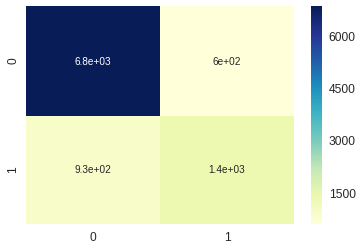

In [18]:
def make_heat_map(mx, size=(10,10)):
  sns.heatmap(mx
              , annot=True
              , annot_kws={"Size" : 10}
              , cmap="YlGnBu")
  plt.figure(figsize=size)
  plt.show()

make_heat_map(base_rf_conf_mx)

The top 5 feature importances are shown below. Age is the strongest predictor but the top 5 predictors only account for just over 0.5 predictive importance.

Feature ranking:
1. feature age (0.216711)
2. feature capital-gain (0.112471)
3. feature hours-per-week (0.104324)
4. feature education-num (0.060663)
5. feature capital-loss (0.032615)


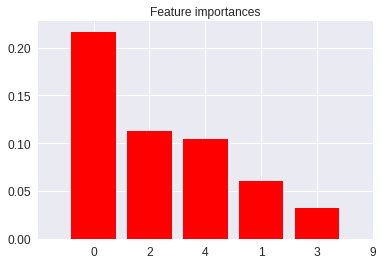

In [19]:
def get_top_importances(model, columns, n=5):
  importances = model.feature_importances_[:10]
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(n):
      print("%d. feature %s (%f)" % (f + 1, columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(n), importances[indices[:n]],
         color="r", align="center")
  plt.xticks(range(10), indices)
  plt.xlim([-1, n])
  plt.show()
  
get_top_importances(rnd_clf, X_train.columns, 5)

The AUROC score is pretty high. It looks like a well performing model.

In [23]:
base_rf_auc = roc_auc_score(y_test, base_rf_y_pred_prob_test[:,1])
print('Area Under the ROC: {}'.format(round(base_rf_auc, 4)))

Area Under the ROC: 0.8681


## ADA Boosting

Next a model is developed using the ADA boost method. This creates a series sequential simple models using 1 or some small number of predictors, updating the weights of observations based on their misclassification and training a new model on these new weighted observations. These are very simple models however they are aggregated together which form a much more complex voting algorithm. 

In [22]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#create a dictionary of parameters 
lr = np.arange(0.2, 1.2, 0.2)
n_est = np.arange(100, 500, 100)

ada_param_grid = {'n_estimators':n_est
                 , 'learning_rate':lr
                 , 'random_state':[0]}

ada_clf = AdaBoostClassifier()

ada_clf_grid = GridSearchCV(ada_clf
                            , ada_param_grid
                            , cv = 5
                            , refit = True
                            , n_jobs=-1
                            , verbose = 1)

ada_clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([100, 200, 300, 400]), 'learning_rate': array([0.2, 0.4, 0.6, 0.8, 1. ]), 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The output from the best estimator object is the ADA-boost classifier with the best parameters (rated by cross validation) obtained from the grid search. These model is then used to make predictions on the train and test data, calculate the model score, confusion matrix, and classification report. 

In [24]:
ada_clf_best_estimator = ada_clf_grid.best_estimator_
ada_clf_best_params = ada_clf_grid.best_params_
print("Best ADA Model Parameters: {}".format(ada_clf_best_params))

Best ADA Model Parameters: {'learning_rate': 1.0, 'n_estimators': 400, 'random_state': 0}


In [26]:
ada_rf_y_pred_train = ada_clf_best_estimator.predict(X_train)
ada_rf_y_pred_prob_train = ada_clf_best_estimator.predict_proba(X_train)

ada_rf_y_pred_test = ada_clf_best_estimator.predict(X_test)
ada_rf_y_pred_prob_test = ada_clf_best_estimator.predict_proba(X_test)

ada_rf_score_train = ada_clf_best_estimator.score(X_train, y_train)
ada_rf_score = ada_clf_best_estimator.score(X_test, y_test)
ada_rf_conf_mx = confusion_matrix(y_test, base_rf_y_pred_test)
ada_rf_class_report = classification_report(y_test, base_rf_y_pred_test)

print('Model Score (train): {}'.format(round(ada_rf_score_train,4)))
print('Model Score (test): {}'.format(round(ada_rf_score, 4)))
print('\nConfusion Matrix\n',ada_rf_conf_mx)
print('\nClassification Report\n',ada_rf_class_report)

Model Score (train): 0.8727
Model Score (test): 0.8661

Confusion Matrix
 [[6835  600]
 [ 932 1402]]

Classification Report
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      7435
           1       0.70      0.60      0.65      2334

   micro avg       0.84      0.84      0.84      9769
   macro avg       0.79      0.76      0.77      9769
weighted avg       0.84      0.84      0.84      9769



The model performance has somewhat improved. Not drastically but the weak learning method has definitley improved the model performance and robustness. 

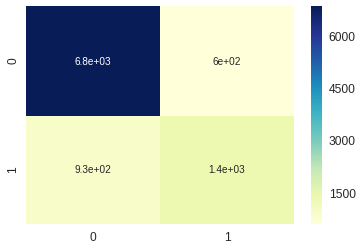

In [30]:
make_heat_map(ada_rf_conf_mx)

Feature ranking:
1. feature capital-gain (0.350000)
2. feature capital-loss (0.332500)
3. feature age (0.085000)
4. feature hours-per-week (0.022500)
5. feature education-num (0.012500)


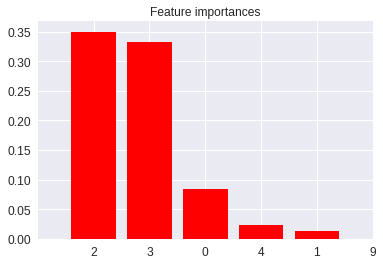

In [31]:
get_top_importances(ada_clf_best_estimator, X_train.columns, 5)

From the feature importance plot above, the feature importances of the top 5 have a sum of over 0.8. These are the stumps which have honed on these weighted observations, particularly the capital-gain and capital-loss predictors.

The AUCROC has improved as well.

In [32]:
ada_rf_auc = roc_auc_score(y_test, ada_rf_y_pred_prob_test[:,1])
print('Area Under the ROC: {}'.format(round(ada_rf_auc, 4)))

Area Under the ROC: 0.9242


The model is also much less overfit if at all. 

## Gradient Boosting

Next a model is generated using the gradient boosted method which uses the residuals of a model as input to the next model to be trained.

In [33]:
#create a dictionary of parameters 
lr = np.arange(0.2, 1.2, 0.2)
n_est = np.arange(100, 500, 100)
max_dep = np.array([1,2])

gb_param_grid = {'n_estimators':n_est
                , 'learning_rate':lr
                , 'max_depth':max_dep
                , 'random_state':[99]}

gb_clf = GradientBoostingClassifier()

gb_clf_grid = GridSearchCV(gb_clf
                           , gb_param_grid
                           , cv = 5
                           , refit = True
                           , n_jobs=-1
                           , verbose = 1)

gb_clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([100, 200, 300, 400]), 'learning_rate': array([0.2, 0.4, 0.6, 0.8, 1. ]), 'max_depth': array([1, 2]), 'random_state': [99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

The output from the best estimator object is the Gradent Boost classifier with the best parameters (rated by cross validation) obtained from the grid search. These model is then used to make predictions on the train and test data, calculate the model score, confusion matrix, and classification report. 

In [34]:
gb_clf_best_estimator = gb_clf_grid.best_estimator_
gb_clf_best_params = gb_clf_grid.best_params_
print("Best GB Model Parameters: {}".format(gb_clf_best_params))

Best GB Model Parameters: {'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 400, 'random_state': 99}


In [39]:
gb_rf_y_pred_train = gb_clf_best_estimator.predict(X_train)
gb_rf_y_pred_prob_train = gb_clf_best_estimator.predict_proba(X_train)

gb_rf_y_pred_test = gb_clf_best_estimator.predict(X_test)
gb_rf_y_pred_prob_test = gb_clf_best_estimator.predict_proba(X_test)

gb_rf_score_train = gb_clf_best_estimator.score(X_train, y_train)
gb_rf_score = gb_clf_best_estimator.score(X_test, y_test)
gb_rf_conf_mx = confusion_matrix(y_test, gb_rf_y_pred_test)
gb_rf_class_report = classification_report(y_test, gb_rf_y_pred_test)

print('Model Score (train): {}'.format(round(gb_rf_score_train,4)))
print('Model Score (test): {}'.format(round(gb_rf_score, 4)))
print('\nConfusion Matrix\n',gb_rf_conf_mx)
print('\nClassification Report\n',gb_rf_class_report)

Model Score (train): 0.8874
Model Score (test): 0.8715

Confusion Matrix
 [[6999  436]
 [ 819 1515]]

Classification Report
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      7435
           1       0.78      0.65      0.71      2334

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



The model performs just slightly better than the ADA-boost model. However the feature importances look much similar to the standard model. The top 5 features only account for 0.6 of the predictive power.

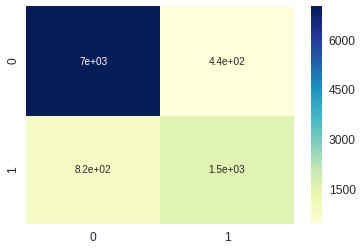

In [40]:
make_heat_map(gb_rf_conf_mx)

Feature ranking:
1. feature capital-gain (0.228600)
2. feature education-num (0.175090)
3. feature capital-loss (0.071660)
4. feature age (0.061781)
5. feature hours-per-week (0.042111)


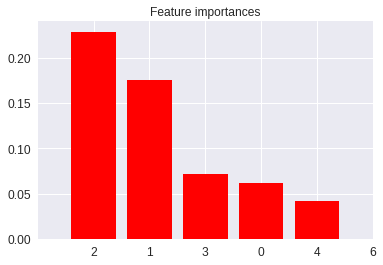

In [41]:
get_top_importances(gb_clf_best_estimator, X_train.columns, 5)

Similar AUROC score to the ADA-boost model and no over fitting what so ever.

In [42]:
gb_rf_auc = roc_auc_score(y_test, gb_rf_y_pred_prob_test[:,1])
print('Area Under the ROC: {}'.format(round(gb_rf_auc, 4)))

Area Under the ROC: 0.9286


## Analysis



5.   The alpha value represents how accurate a given predictor is. It is calculated as the logit of the error rate. If the predictor is performing similarly to random chance, then the alpha value will be close to 0.
6.   Ada boost makes the final prediction by computing the predictions of all the models, weights them by their alpha value and the prediction with the hightest value wins.
7.   The max_depth parameter represents the maximum number of nodes in a tree. This hyper parameter can help tune overfitting by allowing us to reduce the depth a tree can grow to. This can help stop the model from memorizing the training data.
8.   The top 5 features from the models are some ranking of the continuous predictors Age, Education, Hours per Week, Capital-Gain and Capital-Loss. These features confirm what we already know. An older, more educated person who works more hours and has some type of investments versus some who doesn't have those qualities, will be likely make more than $50K USD, approximately the average household income.
9.   Based on the classification reports, the gradient boosted random forest performs the best. The difference between the classification report metrics between train and test are negligible, indicating no overfitting. The optimal hyper-parameters are shown below.
10.  See the below for the ROC plot for the ADA-boost model.





In [0]:
print("Optimal GB Model parameters from grid search:\n {}".format(gb_clf_best_params))

In [0]:
def create_roc_plot(y_test, y_hat_test_prob):
  # limit to probability for class = 1 
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(20):
      fpr[i], tpr[i], _ = roc_curve(y_test, y_hat_test_prob)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  plt.plot(fpr[1], tpr[1])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.show()
  
  
create_roc_plot(y_test ,ada_rf_y_pred_prob_test[:,1])


In [0]:
!jupyter nbconvert --to html '/content/gdrive/My Drive/Code/Machine Learning & Predictive Analytics/Homework 6/Homework 6.ipynb'